In [7]:
from orphics import io, maps, lensing, cosmology, stats
from pixell import enmap, curvedsky
import numpy as np
import os, sys
import healpy as hp
import matplotlib.pylab as plt
import symlens as s
from symlens import utils
import importlib
from mpi4py import MPI
import pandas as pd
import tools

In [8]:
# Simulate bias of lensing reconstruction from non-Gaussian kSZ

# map source, 'Colin' or 'websky'
map_source = 'Colin'
# 'lt' for late-time kSZ or 'ri' for reionization kSZ
ksz_type = 'lt'

# experiment configuration, name:[nlev_t,beam_arcmin]
experiments={'CMB_S4':[1,3]}
#experiments = {'Planck_SMICA':[45,5], 'CMB_S3':[7,1.4], 'CMB_S4':[1,3]}

# Use maps provided by websky
map_path = 'maps/' + map_source + '/'
# Path of output data
data_path = 'data/'

# lmin, lmax for cmb maps
ellmin = 100
ellmaxs = [4000]
# ellmaxs = [3000, 4000, 4500]
# bin width for reconstructed kappa powerspectrum
delta_L = 40

# pixel size in arcmin
px_arcmin = 1.
# size of cutout square
width_deg = 30

# Let's define a cut-sky cylindrical geometry with 1 arcminute pixel width
# and a maximum declination extent of +- 15 deg (see below for reason)
# band width in deg
decmax = 60
# shape and wcs  of the band
band_shape, band_wcs = enmap.band_geometry(dec_cut=np.deg2rad(decmax),
                                           res=np.deg2rad(px_arcmin / 60.))

band_modlmap = enmap.modlmap(band_shape, band_wcs)

# Read in cmb_alm
cmb_alm = hp.read_alm(map_path + 'lensed_cmb_alm.fits', hdu=1)
# Get cmb band map
cmb_band = curvedsky.alm2map(cmb_alm, enmap.empty(band_shape, band_wcs))

# Read in ksz_alm and get ksz band map
ksz_alm = hp.read_alm(map_path + f'ksz_{ksz_type}_alm.fits')
ksz_band = curvedsky.alm2map(ksz_alm, enmap.empty(band_shape, band_wcs))

# Read in ksz_g_alm  and get ksz_g_band map, 'g' is for gaussian
ksz_g_alm = hp.read_alm(map_path +f'ksz_{ksz_type}_g_alm_6000.fits')
ksz_g_band = curvedsky.alm2map(ksz_g_alm, enmap.empty(band_shape, band_wcs))


# Read in input kappa map for cross correlation check
kap_alm = hp.read_alm(map_path + 'kappa_alm.fits')
kap_band = curvedsky.alm2map(kap_alm, enmap.empty(band_shape, band_wcs))


In [9]:
data_path = 'data/test/'
importlib.reload(tools)

<module 'tools' from '/global/cscratch1/sd/hongbo/new_reion-lens/tools.py'>

In [10]:
# loop for different experiments and ellmax
for experiment_name, value in experiments.items():
    for ellmax in ellmaxs:

        nlev_t = value[0]
        beam_arcmin = value[1]
        ells = np.arange(0, ellmax, 1)
        # lmin, lmax for reconstructed kappa map
        Lmin, Lmax = 40, ellmax
        # noise power spectrum
        Cl_noise_TT = (nlev_t * np.pi / 180. / 60.)**2 * np.ones(ells.shape)
        # deconvolved noise power spectrum
        Cl_noise_TT = Cl_noise_TT / utils.gauss_beam(ells, beam_arcmin)**2
        # deconvolved noise band map
        noise_band = curvedsky.rand_map(band_shape, band_wcs, Cl_noise_TT)
        
        
        Ls, Data = tools.ksz_lens(ellmin, ellmax, nlev_t, beam_arcmin, px_arcmin, width_deg,
                                 cmb=cmb_band, noise=noise_band, ksz=ksz_band, ksz_g=ksz_g_band,
                                 inkap=kap_band).get_bias(Lmin, Lmax, delta_L)

        # Store autospectra and their bias in a dictionary
        Data_dict = {
            "Ls": Ls,
            "reckap_x_reckap_t": Data.stats['reckap_x_reckap_t']['mean'],
            "reckap_x_reckap_t_err": Data.stats['reckap_x_reckap_t']['err'],
            "bias": Data.stats['bias']['mean'],
            "bias_err": Data.stats['bias']['err']
        }
         
        Data_df = pd.DataFrame(Data_dict)
        Data_df.to_csv(data_path + map_source + '_' + ksz_type + '_%s_%s_%s.csv' %
                       (experiment_name, ellmin, ellmax), index=False)

In [11]:
bias1 = pd.read_csv('data/test/Colin_lt_CMB_S4_100_4000.csv')
#bias2 = pd.read_csv('data/test/websky_ri_CMB_S4_100_4000.csv')

In [26]:
experiment_names = [ name for name in experiments.keys()]
experiment_names[0]

'CMB_S4'

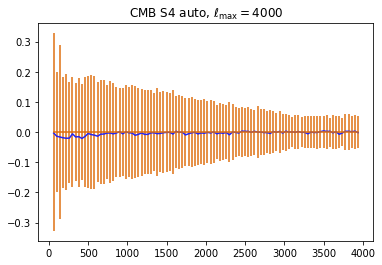

In [43]:
plt.plot(bias1['Ls'], bias1['bias'])
plt.errorbar(bias1['Ls'], np.zeros(np.shape(bias1['Ls'])), yerr=bias1['bias_err'])
plt.title(r'CMB S4 auto, ${\ell}_{\mathrm{max}}=%s$' %ellmax)
plt.savefig('data/test/'+map_source+'_'+ksz_type+'_'+experiment_names[0]+'_'+'.png')